## **Fine-tuned the DistilBERT model using the European Restaurant Reviews dataset, for Sentiment Analysis**

## Project Overview
This notebook demonstrates how to fine-tune a DistilBERT model for sentiment analysis using European restaurant reviews. The complete process will be from data loading to model evaluation, and proper handling of class imbalance, and overfitting prevention.

- **Dataset**: European Restaurant Reviews with positive/negative sentiments
- **Model**: DistilBERT (Distilled BERT) for efficient training
- **Techniques**: Class weighting, early stopping, dropout regularization
- **Evaluation**: Comprehensive metrics and visualization

*   List item
*   List item



## 1. Environment Setup

### 1.1 Dataset Information

## European Restaurant Reviews
Reviews of various European restaurants by customers.

Dataset
European Restaurant Reviews dataset from Kaggle containing customer reviews for various restaurants, divided into positive and negative sentiments.

**Dataset URL**: https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews

### 1.2 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


### 1.3 Install Required Dependencies

In [ ]:
!pip install --upgrade transformers

### 1.4 Import Required Libraries
This section imports all necessary libraries for data processing, machine learning, and deep learning operations.

**Library Categories:**
- **Data Processing**: pandas, numpy for data manipulation
- **Visualization**: matplotlib, seaborn for plotting
- **NLP**: nltk, wordcloud for text processing
- **Machine Learning**: scikit-learn for traditional ML algorithms and metrics
- **Deep Learning**: transformers, torch for BERT fine-tuning
- **Utilities**: warnings, os for environment management

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_colwidth', 160)

# Natural Language Processing (NLP)
import nltk
from wordcloud import WordCloud
nltk.download('punkt_tab')
#nltk.download('wordnet')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

from transformers import (
    TrainerCallback, Trainer, TrainingArguments,
    EarlyStoppingCallback, DistilBertForSequenceClassification,
    DistilBertConfig
)

import joblib
import pickle
from imblearn.over_sampling import SMOTE

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,TrainerCallback
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### 1.5 Check Working Directory
Verify the current working directory to ensure proper file path references.

In [ ]:
import os
# Disable wandb to avoid authentication issues
os.environ["WANDB_DISABLED"] = "true"
print(os.getcwd())

/content


## 2. Data Loading and Exploration

### 2.1 Load the Dataset
Load the European Restaurant Reviews dataset from Google Drive. This dataset contains customer reviews with sentiment labels (Positive/Negative).

**Dataset Structure:**
- **Country**: Location of the restaurant
- **Restaurant Name**: Name of the reviewed restaurant
- **Sentiment**: Target variable (Positive/Negative)
- **Review Title**: Short title of the review
- **Review Date**: When the review was posted
- **Review**: Full text of the customer review (our main feature)

In [ ]:
# Read CSV file
df = pd.read_csv('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/EuropeanRestaurantReviews.csv')
df.head(2)

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brough..."


### 2.2 Dataset Size
Check the total number of records in our dataset.

In [ ]:
len(df)

1502

### 2.5 Data Quality Check
Examine the dataset for missing values, duplicates, and data quality issues.

### 2.3 Column Information
Examine the column names and structure of our dataset.

In [ ]:
df.columns

Index(['Country', 'Restaurant Name', 'Sentiment', 'Review Title',
       'Review Date', 'Review'],
      dtype='object')

### 2.4 Data Preprocessing
Clean column names by removing spaces for easier handling in code.

In [ ]:
df = df.rename(columns={'Review Title': 'ReviewTitle'})
df = df.rename(columns={'Restaurant Name': 'RestaurantName'})
df = df.rename(columns={'Review Date': 'ReviewDate'})

In [ ]:
# Map sentiment labels to numerical values
df['Label'] = df['Sentiment'].map({'Positive': 1,'Negative': 0,})
df.iloc[128:132]

,Country,RestaurantName,Sentiment,ReviewTitle,ReviewDate,Review,Label
128,France,The Frog at Bercy Village,Negative,Overrated and touristy,Mar 2024 •,Unfortunately the food was just average. No dish was really convincing. The greeting from the kitchen was okay but not a highlight in terms of taste.\n\nThe...,0
129,France,The Frog at Bercy Village,Negative,Bad tasting food difficult to digest,Oct 2023 •,We didn't like the food that much.\n\nThe starters were tasteless\n\nand hard to digest.\n\nThe pasta was nothing special.\n\nThe main course was cooked for...,0
130,France,The Frog at Bercy Village,Negative,Pretty dissappointing.,Feb 2022 •,"I actually never write reviews for the restaurants, but for this one i just had to. The reason we decided to check this place out was only because of high r...",0
131,France,The Frog at Bercy Village,Negative,Sorry,Feb 2012 •,I'm afraid we were very let down by this restaurant.\nWe were left standing at the door for 5 minutes before being seated. We decided on the tasting menu fo...,0


## 3. Exploratory Data Analysis

### 3.1 Sentiment Distribution
Analyze the distribution of positive and negative sentiments in our dataset to understand class balance.

In [ ]:
# Combine the ReviewTitle and Review columns into a single 'combined' column
df["Combined"] = (df.ReviewTitle.str.strip() + df.Review.str.strip())
df.head(2)

,Country,RestaurantName,Sentiment,ReviewTitle,ReviewDate,Review,Label,Combined
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.,0,Rude managerThe manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brough...",0,"A big disappointmentI ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20..."


In [ ]:
# Select the necessary columns
df = df[["Sentiment", "Label","Combined"]]
df = df.rename(columns={'Combined': 'Review'})

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/Reviews.csv', index=False)

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/Reviews.csv')

# Display the first few rows of the DataFrame
df.head(2)

,Sentiment,Label,Review
0,Negative,0,Rude managerThe manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.
1,Negative,0,"A big disappointmentI ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20..."


In [ ]:
df.columns

Index(['Sentiment', 'Label', 'Review'], dtype='object')

In [ ]:
print(df.dtypes)

Sentiment    object
Label         int64
Review       object
dtype: object


### 3.2 Text Length Analysis
Examine the length distribution of reviews to understand text characteristics.

In [ ]:
#Check all missing value in dataset
df_missing_values= df.isnull().sum()
df_missing_values

,0
Sentiment,0
Label,0
Review,0


In [ ]:
df.duplicated().sum()

np.int64(76)

In [ ]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [ ]:
#Find unique values in df['Sentiment']
unique_Sentiment= df['Sentiment'] .unique()
print(unique_Sentiment)

['Negative' 'Positive']


In [ ]:
df_Sentiment_counts = df['Sentiment'].value_counts()
df_Sentiment_counts

,count
Sentiment,
Positive,1237
Negative,189


### 3.3 Word Cloud Visualization
Create word clouds to visualize the most common words in positive and negative reviews.

### There is an imbalanced dataset of sentiments between Positive and Negative

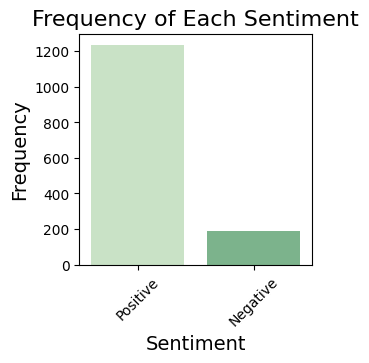

In [ ]:
#Plot Sentiment
plt.figure(figsize=(3, 3))
sns.barplot(x=df_Sentiment_counts.index, y=df_Sentiment_counts.values, palette='Greens',alpha=0.7)
plt.title('Frequency of Each Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.show()

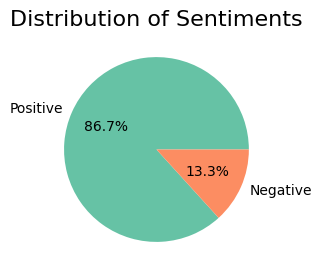

In [ ]:
plt.figure(figsize=(3, 3))
plt.pie(df_Sentiment_counts, labels=df_Sentiment_counts.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Sentiments', fontsize=16)
plt.show()

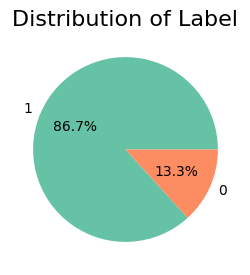

In [ ]:
df_Label_counts = df['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(df_Sentiment_counts, labels=df_Label_counts.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Label', fontsize=16)
plt.show()

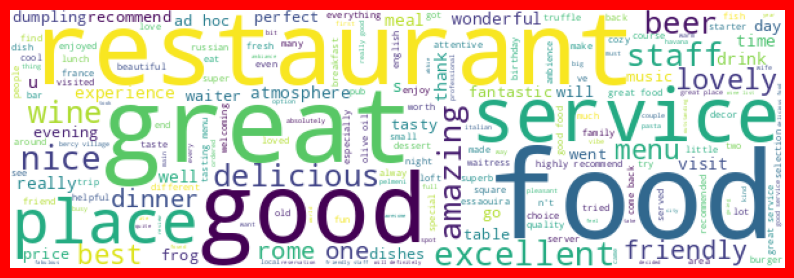

In [ ]:
# Plotting the word cloud of Positive Review Title

pos_words = ""
# Loop all texts where Sentiment is 'Positive'
for value in df[df['Sentiment'] == 'Positive'].Review:
    lowercase_text = value.lower()
    tokens = nltk.word_tokenize(lowercase_text)
    for word in tokens:
        pos_words = pos_words + word + ' '

pos_wordcloud = WordCloud(background_color="White", width=600, height=200).generate(pos_words)

# Plot the word cloud
plt.figure( figsize=(10,10), facecolor='r')
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.show()

## 4. Data Preprocessing for BERT

### 4.1 Label Encoding
Convert sentiment labels to numerical format for model training.

Unlike traditional Machine Learning Models like Logistic Regression, Random Forest, or SVM, which need to convert text data into a numerical format, when using BERT or similar pre-trained transformer models, we don't need to apply traditional text preprocessing steps like TF-IDF, regex cleaning, or other NLP techniques like stemming or lemmatization. BERT models handle these preprocessing steps internally, including tokenization and handling of special characters.

### Fine-tunes DistilBertForSequenceClassification and balancing the imbalanced dataset in the Reviews dataset.

1. Fine-tuning : Directly fine-tune DistilBertForSequenceClassification on the EuropeanRestaurantReviews dataset.

2. Evaluation: Evaluate the fine-tuned model.
   
3. Saving and Loading the Model: Save the fine-tuned model and load it for making predictions.

4. Prediction Function: Use the fine-tuned model to predict sentiment directly from user input.

In [ ]:
# Preprocess the text data using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Function to tokenize data
def tokenize_data(reviews, labels):
    encodings = tokenizer(reviews, truncation=True, padding=True, max_length=128)
    dataset = [{'input_ids': torch.tensor(encodings['input_ids'][i]),
                'attention_mask': torch.tensor(encodings['attention_mask'][i]),
                'labels': torch.tensor(labels[i])} for i in range(len(reviews))]
    return dataset

In [ ]:
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Review'], df['Label'], test_size=0.3, random_state=42)

train_dataset = tokenize_data(train_texts.tolist(), train_labels.tolist())
test_dataset = tokenize_data(test_texts.tolist(), test_labels.tolist())

In [ ]:
# Calculate class weights for handling imbalanced data
class_weights = torch.tensor([len(train_labels) / (len(np.unique(train_labels)) * np.bincount(train_labels))], dtype=torch.float)
class_weights = class_weights.squeeze()

### 4.2 Text Tokenization
Prepare text data for BERT input using DistilBERT tokenizer.

In [ ]:
# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments for fine-tuning DistilBERT

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to=[]  # This disables wandb logging
)

# Compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

To include a chart of performance, including the loss, in the training process, need to extend the Trainer class to log the loss values during training and evaluation. After training, we can plot these metrics to visualize the performance




In [ ]:
import transformers
print(transformers.__version__)

4.52.4


**Must use GPU**

## 5. Model Training

### 5.1 Model Configuration
Set up DistilBERT model with proper configuration for sentiment classification.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with overfitting prevention...
Early stopping will trigger if validation loss doesn't improve for 2 epochs


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.694300,0.685514,0.812500,0.888571,0.917404,0.861496
2,0.637500,0.614126,0.913462,0.952381,0.911392,0.997230
3,0.354000,0.306720,0.949519,0.970793,0.974860,0.966759
4,0.267200,0.195161,0.959135,0.976422,0.977778,0.975069
5,0.141300,0.207783,0.961538,0.977716,0.983193,0.972299
6,0.334000,0.349925,0.963942,0.979536,0.965054,0.994460


Training completed!


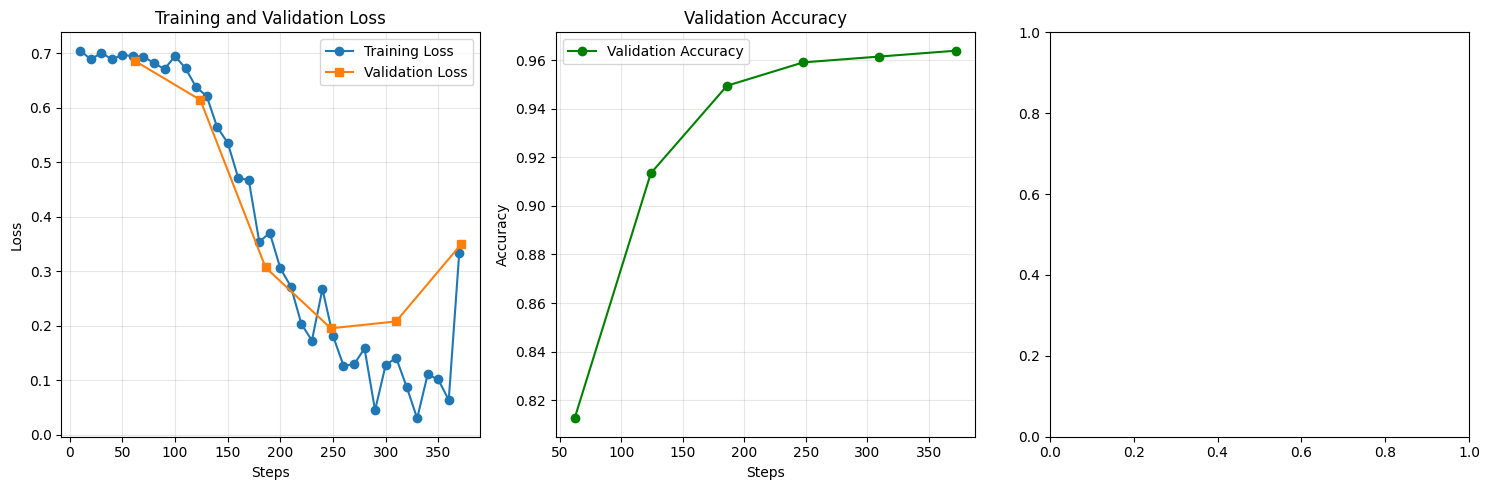


Final Results:
Best Validation Accuracy: 0.9639
Final Validation Loss: 0.3499


In [ ]:
# Callback to log loss and metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {'train_loss': [], 'eval_loss': [], 'eval_accuracy': []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.metrics['train_loss'].append((state.global_step, logs['loss']))
        if 'eval_loss' in logs:
            self.metrics['eval_loss'].append((state.global_step, logs['eval_loss']))
        if 'eval_accuracy' in logs:
            self.metrics['eval_accuracy'].append((state.global_step, logs['eval_accuracy']))

# Subclass Trainer with proper device handling
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            device_weights = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=device_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# OPTION 1: Load model with custom dropout configuration
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = 2
config.dropout = 0.3  # Set dropout rate
config.attention_dropout = 0.3  # Set attention dropout rate

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    config=config
)

# OPTION 2: Simple approach with default dropout (uncomment to use instead)
# model = DistilBertForSequenceClassification.from_pretrained(
#     'distilbert-base-uncased',
#     num_labels=2
# )

# Improved training arguments with overfitting prevention
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,  # Reduced from 5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,  # L2 regularization
    learning_rate=2e-5,  # Reduced learning rate
    lr_scheduler_type="cosine",  # Learning rate scheduler
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Use loss instead of accuracy for early stopping
    greater_is_better=False,  # Lower loss is better
    report_to=[],  # Disable wandb
    # Additional overfitting prevention
    dataloader_drop_last=True,  # Drop incomplete batches
    eval_accumulation_steps=1,  # Evaluate more frequently
)

# Initialize callbacks
metrics_callback = MetricsCallback()
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop if no improvement for 2 epochs
    early_stopping_threshold=0.01  # Minimum improvement threshold
)

# Trainer initialization with overfitting prevention
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback, early_stopping_callback],
)

# Train the model
print("Starting training with overfitting prevention...")
print("Early stopping will trigger if validation loss doesn't improve for 2 epochs")
trainer.train()
print("Training completed!")

# Plot the loss and accuracy curves
train_loss = metrics_callback.metrics['train_loss']
eval_loss = metrics_callback.metrics['eval_loss']
eval_accuracy = metrics_callback.metrics['eval_accuracy']

if train_loss and eval_loss and eval_accuracy:
    train_steps, train_losses = zip(*train_loss)
    eval_steps, eval_losses = zip(*eval_loss)
    _, eval_accuracies = zip(*eval_accuracy)

    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_steps, train_losses, label='Training Loss', marker='o')
    plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='s')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(eval_steps, eval_accuracies, label='Validation Accuracy', color='green', marker='o')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Loss Difference (Overfitting indicator)
    plt.subplot(1, 3, 3)
    if len(train_steps) == len(eval_steps):
        loss_diff = [eval_loss - train_loss for train_loss, eval_loss in zip(train_losses, eval_losses)]
        plt.plot(eval_steps, loss_diff, label='Validation - Training Loss', color='red', marker='d')
        plt.xlabel('Steps')
        plt.ylabel('Loss Difference')
        plt.title('Overfitting Indicator')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\nFinal Results:")
    print(f"Best Validation Accuracy: {max(eval_accuracies):.4f}")
    print(f"Final Validation Loss: {eval_losses[-1]:.4f}")
else:
    print("No metrics data available for plotting.")

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()
print("Metrics:", metrics)

Metrics: {'eval_loss': 0.19516094028949738, 'eval_accuracy': 0.9591346153846154, 'eval_f1': 0.9764216366158114, 'eval_precision': 0.9777777777777777, 'eval_recall': 0.9750692520775623, 'eval_runtime': 0.3957, 'eval_samples_per_second': 1081.594, 'eval_steps_per_second': 68.231, 'epoch': 6.0}


Interpretation: Fine Tuning increase the performance.


### 5.2 Training Setup
Configure training arguments and initialize the trainer with overfitting prevention techniques.

**Save the Fine-Tuned Model**

In [ ]:
# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/fine-tuned-distilbert')
tokenizer.save_pretrained('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/fine-tuned-distilbert')

print("Fine-tuning complete and model saved.")

Fine-tuning complete and model saved.


### 5.3 Model Training
Train the DistilBERT model with monitoring and evaluation.

**Load The saved Fine-Tuned model**

In [ ]:
# Load the fine-tuned model for predictions
def load_fine_tuned_model():
    model = DistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/fine-tuned-distilbert')
    tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/fine-tuned-distilbert')
    return model, tokenizer

## 6. Model Evaluation

### 6.1 Performance Metrics
Evaluate the trained model using various metrics including accuracy, precision, recall, and F1-score.

In [ ]:
fine_tuned_model, fine_tuned_tokenizer = load_fine_tuned_model()

In [ ]:
# Predict Sentiment based on user input

def predict():
    user_input = input("Enter your message: ")
    encodings = fine_tuned_tokenizer(user_input, truncation=True, padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        outputs = fine_tuned_model(**encodings)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    print('Prediction:', 'Positive' if prediction == 1 else 'Negative')

In [ ]:
predict()

Enter your message: the wine was bad
Prediction: Negative


In [ ]:
predict()

Enter your message: the manager is nice
Prediction: Positive


### 6.2 Visualization
Visualize training progress and model performance through plots and charts.

##### **After Fine-Tuned, the DistilBertForSequenceClassification model can predict the sentiment better**

In [ ]:
# Get predictions for the test set
test_encodings = fine_tuned_tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_outputs = fine_tuned_model(**test_encodings)
test_preds = torch.argmax(test_outputs.logits, dim=1).numpy()

In [ ]:
# Calculate accuracy score
accuracy = accuracy_score(test_labels, test_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9603


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
nconf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis], 2)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 50   8]
 [  9 361]]


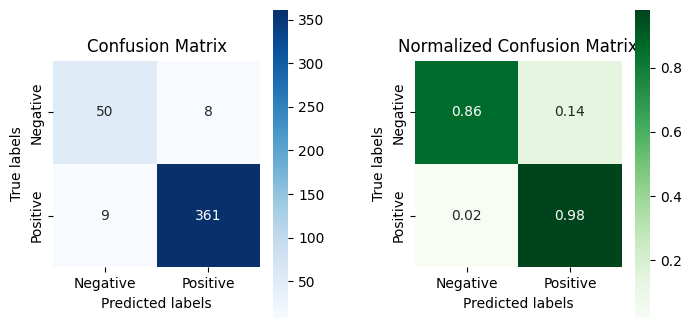

In [ ]:
# Plot heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix")
sns.heatmap(nconf_matrix, annot=True, cmap=plt.cm.Greens, fmt=".2f", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Normalized Confusion Matrix")

# Add some space between the subplots
plt.subplots_adjust(wspace=0.4)

# Set the aspect ratio to "equal"
ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()

## 7. Model Deployment and Storage
### 7.1 Save Model and Tokenizer to Hugging Face Hub

After successfully training our DistilBERT model, we need to save and deploy it for future use. Hugging Face Hub provides an excellent platform for hosting machine learning models with the following benefits:

**Uploaded:**
- **model.safetensors** (261 MB) - fine-tuned weights
- **tokenizer.json** - Tokenizer configuration
- **config.json** - Model configuration  
- **vocab.txt** - Vocabulary file
- **README.md** - Model documentation

This is to solve GitHub file size limitation (100MB) while making the model easily accessible to others.


# **Save Model and Tokenizer to Hugging Face**

### 7.2 Install Hugging Face Hub
First, we need to install the Hugging Face Hub library to enable model uploading functionality.


In [1]:
!pip install -qqq huggingface_hub

### 7.3 Authentication Setup
To upload models to Hugging Face Hub, we need to authenticate using an access token.

**Steps to get your token:**
1. Go to https://huggingface.co/settings/tokens
2. Click "New token"
3. Select "Write" permissions (required for uploading)
4. Copy the token (starts with )

**Security Note:** The  function hides your token input for security.


In [2]:
from huggingface_hub import login
import getpass
from huggingface_hub import login

# Secure token input (token will be hidden)
print("Please enter your Hugging Face token:")
print("Get it from: https://huggingface.co/settings/tokens" )
token = getpass.getpass("HF Token: ")

# Login with the token
try:
    login(token=token)
    print("Successfully logged in!")
except Exception as e:
    print(f"Login failed: {e}")

Please enter your Hugging Face token:
Get it from: https://huggingface.co/settings/tokens
HF Token: ··········
Successfully logged in!


# **Upload Model and Tokenizer to Hugging Face**

### 7.4 Upload Model and Tokenizer to Hugging Face Hub
This section uploads both the fine-tuned model and tokenizer to your Hugging Face repository.

**Upload Process:**
1. **Model Upload**: Uploads the 261MB model.safetensors file
2. **Tokenizer Upload**: Uploads tokenizer configuration and vocabulary
3. **Local Backup**: Saves a copy to Google Drive as backup
4. **Error Handling**: Falls back to local save if upload fails

**Repository Structure Created:**
-  - Model configuration,Trained model weights, Tokenizer configuration, Vocabulary mapping, Auto-generated model card


In [3]:
repo_name = "RinInori/distilbert-restaurant-sentiment"

In [4]:
# Upload directly to Hugging Face

print("Uploading model and tokenizer to Hugging Face Hub...")

try:
    # Upload model directly after training
    print("Uploading model...")
    model.push_to_hub(repo_name)
    print("Model uploaded successfully!")

    # Upload tokenizer
    print("Uploading tokenizer...")
    tokenizer.push_to_hub(repo_name)
    print("Tokenizer uploaded successfully!")

    print(f"Fine-tuning complete and model uploaded!")
    print(f"View your model at: https://huggingface.co/{repo_name}" )

    # Optional: Also save locally as backup
    local_path = '/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/fine-tuned-distilbert'
    model.save_pretrained(local_path)
    tokenizer.save_pretrained(local_path)
    print(f"Also saved locally as backup at: {local_path}")

except Exception as e:
    print(f"Upload failed: {e}")
    print("Saving locally as fallback...")

    # Fallback: save locally if upload fails
    local_path = '/content/drive/MyDrive/FineTuning_Embedding_SentimentAnalysis-main/data/fine-tuned-distilbert'
    model.save_pretrained(local_path)
    tokenizer.save_pretrained(local_path)
    print(f"Model saved locally at: {local_path}")


### 7.5 Model Access Information
Once uploaded, the model becomes publicly accessible through these URLs


Model URLs:

Model Page: https://huggingface.co/RinInori/distilbert-restaurant-sentiment

Files: https://huggingface.co/RinInori/distilbert-restaurant-sentiment/tree/main

### 7.6 Public Model Usage Example
Anyone can load and use my uploaded model with just two lines of code. Model easily accessible to the machine learning community.


In [5]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("RinInori/distilbert-restaurant-sentiment")

tokenizer = DistilBertTokenizer.from_pretrained("RinInori/distilbert-restaurant-sentiment" )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## 8. Model Validation and Testing
### 8.1 Load and Test Model from Hugging Face Hub

After uploading, will verify that the model works correctly when loaded from Hugging Face Hub.

# **Load the Model and Tokenizer from Hugging Face**

In [ ]:
# Test loading from Hugging Face Hub
print("Testing uploaded model...")

try:
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
    import torch

    # Load from your uploaded repository
    test_tokenizer = DistilBertTokenizer.from_pretrained(repo_name)
    test_model = DistilBertForSequenceClassification.from_pretrained(repo_name)

    print("Successfully loaded from Hugging Face Hub!")

    # Quick test
    test_text = "The restaurant had amazing food and excellent service!"
    inputs = test_tokenizer(test_text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = test_model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

        sentiment = "Positive" if predicted_class == 1 else "Negative"

    print(f"Test Result: {sentiment} (confidence: {confidence:.4f})")

except Exception as e:
    print(f"Test failed: {e}")


Testing uploaded model...


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Successfully loaded from Hugging Face Hub!
Test Result: Positive (confidence: 0.9553)
